# Preparando el terreno

## Librerias

In [1]:
import janitor
import matplotlib.pyplot as plt
import missingno
import nhanes.load
import numpy as np
import pandas as pd
import scipy.stats
import seaborn as sns
import session_info
import sklearn.compose
import sklearn.impute
import sklearn.preprocessing
import statsmodels.api as sm
import statsmodels.datasets
import statsmodels.formula.api as smf
from IPython.display import Image

from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.kernel_approximation import Nystroem
from sklearn.linear_model import BayesianRidge, Ridge
from sklearn.neighbors import KNeighborsRegressor
from statsmodels.graphics.mosaicplot import mosaic

import warnings
warnings.filterwarnings('ignore')

## Funciones utiles

In [2]:
%run /root/Platzi/CurDatosFalt_2/pd_api_extend.ipynb

## Aspecto de las graficas

In [3]:
%matplotlib inline

sns.set(
    rc={
        "figure.figsize": (8, 6)
    }
)

sns.set_style("whitegrid")

# Problema por trabajar con valores faltantes

In [4]:
airquality_df = (
    sm.datasets.get_rdataset("airquality")
    .data
    .clean_names(
        case_type = "snake"
    )
    .add_column("year", 1973)
    .assign(
        date = lambda df: pd.to_datetime(df[["year", "month", "day"]])
    )
    .sort_values(by = "date")
    .set_index("date")
)

airquality_df

,ozone,solar_r,wind,temp,month,day,year
date,,,,,,,
1973-05-01,41.0,190.0,7.4,67,5,1,1973
1973-05-02,36.0,118.0,8.0,72,5,2,1973
1973-05-03,12.0,149.0,12.6,74,5,3,1973
1973-05-04,18.0,313.0,11.5,62,5,4,1973
1973-05-05,NaN,NaN,14.3,56,5,5,1973
...,...,...,...,...,...,...,...
1973-09-26,30.0,193.0,6.9,70,9,26,1973
1973-09-27,NaN,145.0,13.2,77,9,27,1973
1973-09-28,14.0,191.0,14.3,75,9,28,1973


In [5]:
smf.ols(formula="temp ~ ozone + solar_r", data=airquality_df).fit().summary().tables[0]

Dep. Variable:,temp,R-squared:,0.491
Model:,OLS,Adj. R-squared:,0.481
Method:,Least Squares,F-statistic:,52.07
Date:,"Wed, 05 Jun 2024",Prob (F-statistic):,1.47e-16
Time:,15:04:28,Log-Likelihood:,-369.78
No. Observations:,111,AIC:,745.6
Df Residuals:,108,BIC:,753.7
Df Model:,2,,
Covariance Type:,nonrobust,,


se pierden observaciones por los valores faltantes, este algoritmo esta descartando los valores faltantes.

# Datos de nhanes

In [6]:
nhanes_raw_df = (
    nhanes.load.load_NHANES_data(year="2017-2018")
    .clean_names(
        case_type = "snake"
    )
)


In [7]:
nhanes_df = (
    nhanes_raw_df.select_columns(
        "general_health_condition",
        "age_in_years_at_screening",
        "gender",
        "current_selfreported_height_inches",
        "current_selfreported_weight_pounds",
        "doctor_told_you_have_diabetes",
        "60_sec_pulse30_sec_pulse2",
        "total_cholesterol_mgdl"
    )
    .rename_columns(
        {
            "age_in_years_at_screening": "age",
            "current_selfreported_height_inches": "height",
            "current_selfreported_weight_pounds": "weight",
            "doctor_told_you_have_diabetes": "diabetes",
            "60_sec_pulse30_sec_pulse2": "pulse",
            "total_cholesterol_mgdl": "total_cholesterol"
        }
    )
    .replace(
        {
            "height": {
                9999: np.nan,
                7777: np.nan
            },
            "weight": {
                9999: np.nan,
                7777: np.nan
            },
            "diabetes": {
                "Borderline": np.nan
            }
        }
    )
    .missing.sort_variables_by_missingness()
    .dropna(
        subset = ["diabetes"],
        how = "any"
    )
    .transform_column(
        column_name = "diabetes",
        function = lambda s: s.astype(int),
        elementwise = False
    )
)

nhanes_df

,height,weight,general_health_condition,total_cholesterol,pulse,diabetes,gender,age
SEQN,,,,,,,,
93703.0,NaN,NaN,NaN,NaN,NaN,0,Female,2.0
93704.0,NaN,NaN,NaN,NaN,NaN,0,Male,2.0
93705.0,63.0,165.0,Good,157.0,52.0,0,Female,66.0
93706.0,68.0,145.0,Very good,148.0,82.0,0,Male,18.0
93707.0,NaN,NaN,Good,189.0,100.0,0,Male,13.0
...,...,...,...,...,...,...,...,...
102951.0,NaN,NaN,NaN,NaN,NaN,0,Male,4.0
102953.0,65.0,218.0,Fair or,182.0,78.0,0,Male,42.0
102954.0,66.0,150.0,Good,172.0,78.0,0,Female,41.0


# Visualizando valores faltantes

<Axes: >

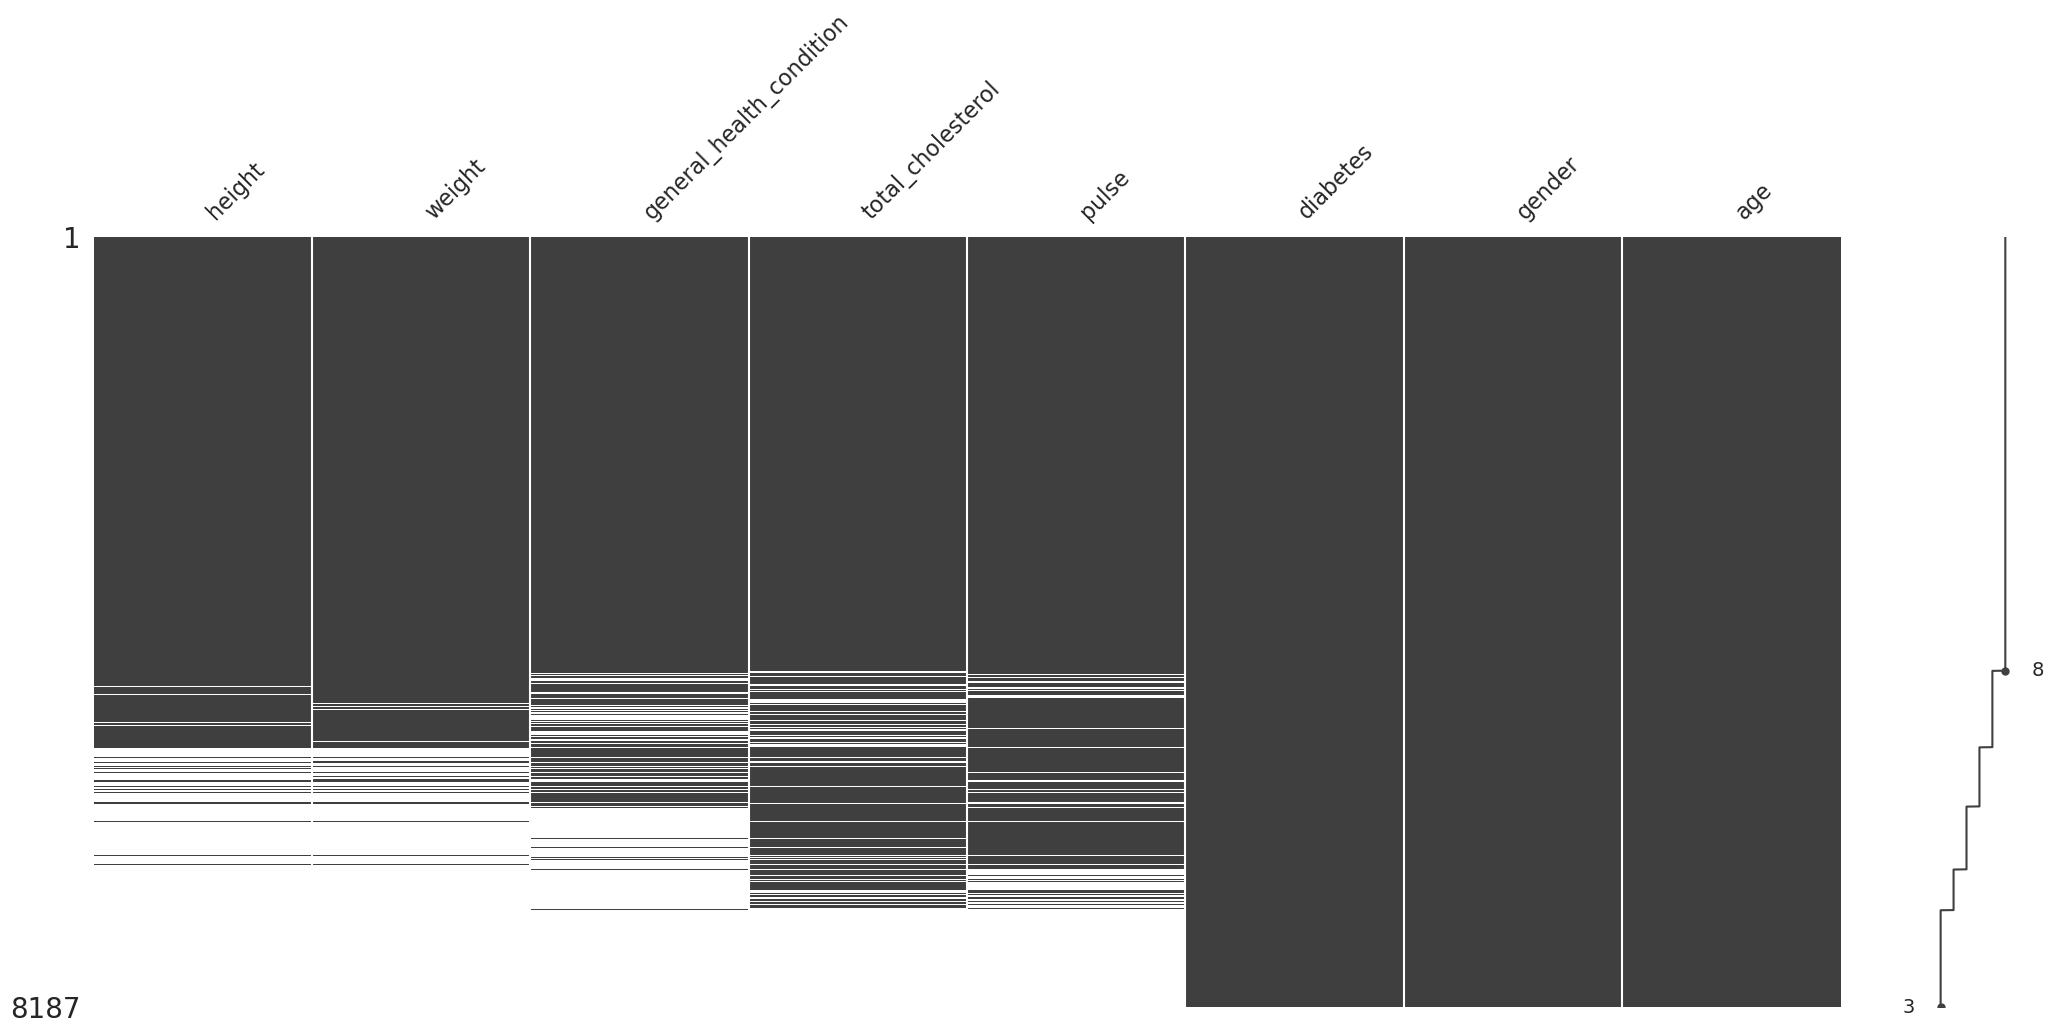

In [8]:
nhanes_df.missing.sort_variables_by_missingness().pipe(missingno.matrix, sort="descending")

{'matrix': <Axes: >,
 'shading': <Axes: >,
 'totals': <Axes: >,
 'intersections': <Axes: ylabel='Intersection size'>}

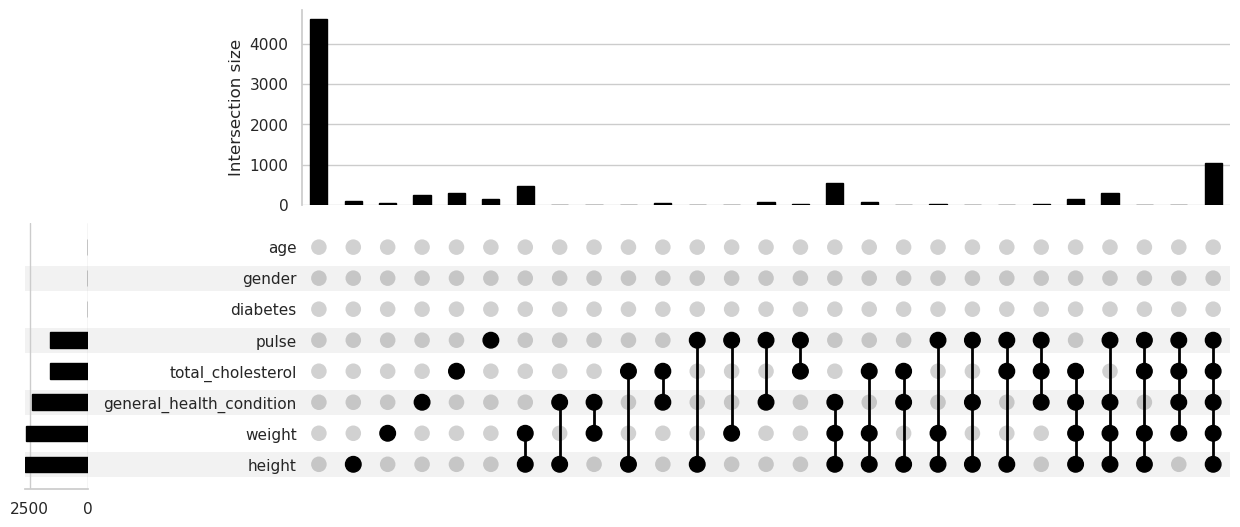

In [9]:
(
    nhanes_df
    .missing.sort_variables_by_missingness()
    .missing.missing_upsetplot()
)

# Tratamiento de valores faltantes:

MCAR:  
-Eliminar: Reduce el tamaño de la muestra, Inferencia limitada, no produce sesgos.  
-Imputar: No introduce sesgos, siempre es mejor imputar que eliminar.  

MAR:  
-Eliminar: Introduce sesgos  
-Imputar: La mayoria de mecanismos de imputación asume que los datos son MAR, la imputación es necesaria en este caso.  s

MNAR:  
-Eliminar: Produce sesgos.  
-Imputar: No es muy buena idea, mejor realizar nuevos experimentos.

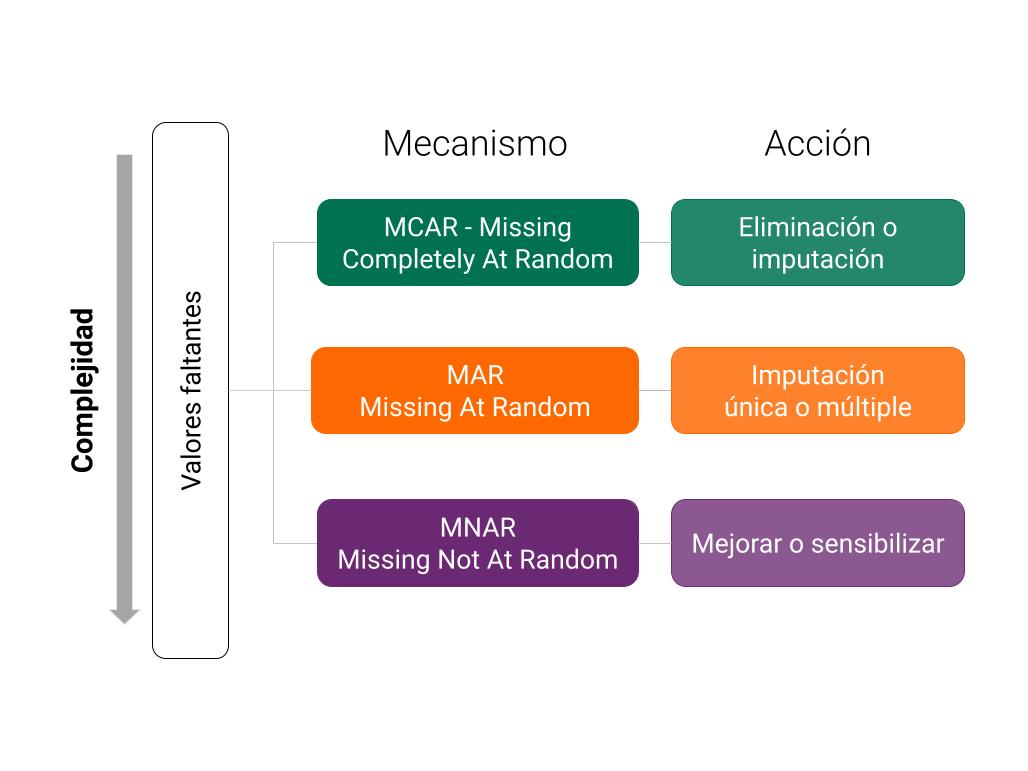

In [10]:
Image("/root/Platzi/CurDatosFalt_2/Images/missing_data_action.jpeg")

## Evaluando el mecanismo presente en los valores faltantes usando t-test

H0: No hay diferencia entre los 
H1: Hay diferencia entre los grupos
Nivel de significancia: 

📘 Información

two-sided: las medias de las distribuciones subyacentes a las muestras son desiguales.  
  
less: la media de la distribución subyacente a la primera muestra es menor que la media de la distribución subyacente a la segunda muestra.  
  
greater: la media de la distribución subyacente a la primera muestra es mayor que la media de la distribución subyacente a la segunda muestra.

In [11]:
female_weight, male_weight = (
    nhanes_df
    .select_columns("gender", "weight")
    .transform_column("weight", lambda x: x.isna(), elementwise = False)
    .groupby("gender")
    .weight
    .pipe(
        lambda df: (
            df.get_group("Female"),
            df.get_group("Male")
        )
    )
)

scipy.stats.ttest_ind(
    a = female_weight,
    b = male_weight,
    alternative="two-sided"
)

TtestResult(statistic=-0.7659832227497865, pvalue=0.443708373452089, df=8185.0)

Vemos que la media del peso en las mujeres es menor a la media del peso de los hombres. Como pvalue > 0.05, nos esta indicando que la diferencia no se debe al azar. 

# Visualización god de valores faltantes

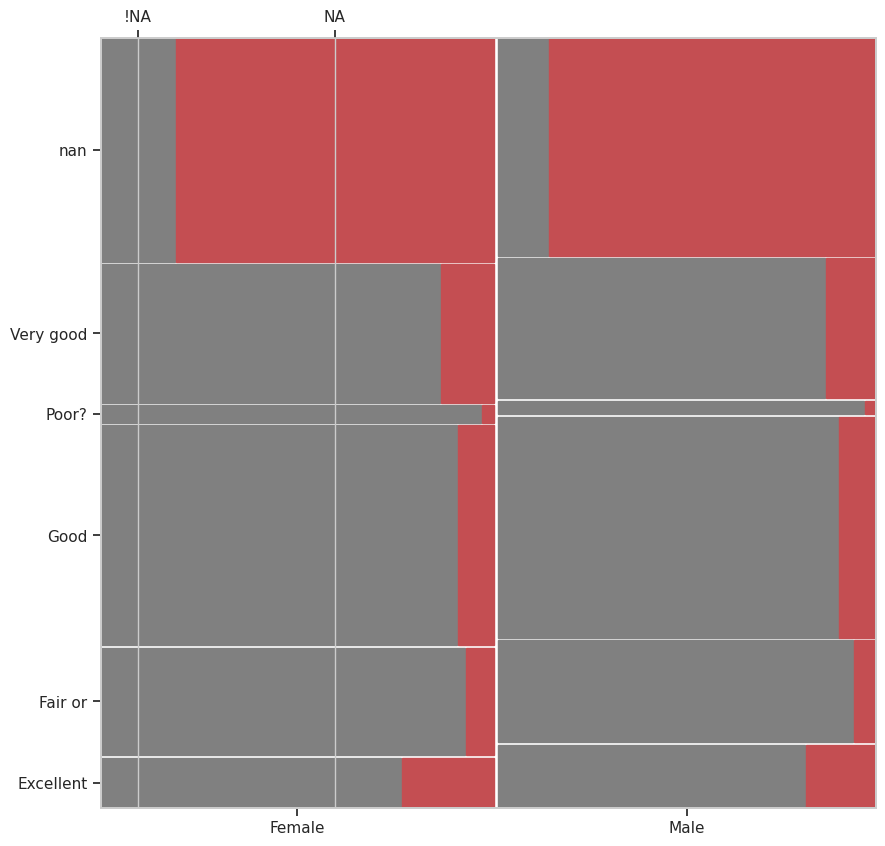

In [12]:
fig, ax = plt.subplots(figsize=(10, 10))

(
    nhanes_df.select_columns("weight", "general_health_condition", "gender")
    .assign(weight=lambda df: df.weight.isna().replace([True, False], ["NA", "!NA"]))
    .groupby(
        ["gender", "general_health_condition", "weight"], dropna=False, as_index=True
    )
    .size()
    .pipe(
        lambda df: mosaic(
            data=df,
            properties=lambda key: {"color": "r" if "NA" in key else "gray"},
            ax=ax,
            horizontal=True,
            axes_label=True,
            title="",
            labelizer=lambda key: "",
        )
    )
)

ax.grid(False)

# Tratamiento de valores faltantes categoricos

## Codificación ordinal

Una codificación ordinal implica mapear cada etiqueta (categoría) única a un valor entero. A su vez, la codificación ordinal también es conocida como codificación entera.

ejemplito:

In [13]:
encoder = sklearn.preprocessing.OrdinalEncoder()

X = [["Male"],  ["Female"], ["Female"]]
X

[['Male'], ['Female'], ['Female']]

In [14]:
encoder.fit_transform(X)

array([[1.],
       [0.],
       [0.]])

In [15]:
encoder.categories_

[array(['Female', 'Male'], dtype=object)]

In [16]:
encoder.inverse_transform([[1], [0], [0]])

array([['Male'],
       ['Female'],
       ['Female']], dtype=object)

Aplicandolo:

In [17]:
nhanes_transformed_df = nhanes_df.copy(deep=True)

In [18]:
categorical_columns = nhanes_df.select_dtypes(object).columns
categorical_columns

Index(['general_health_condition', 'gender'], dtype='object')

In [19]:
categorical_transformer = sklearn.compose.make_column_transformer(
    (sklearn.preprocessing.OrdinalEncoder(), categorical_columns),
    remainder="passthrough"
)

In [20]:
nhanes_transformed_df = (
    pd.DataFrame(
        categorical_transformer.fit_transform(nhanes_df),
        columns = categorical_transformer.get_feature_names_out(),
        index = nhanes_df.index
    )
    .rename_columns(
        function = lambda x: x.removeprefix("ordinalencoder__")
    )
    .rename_columns(
        function = lambda x: x.removeprefix("onehotencoder__")
    )
    .rename_columns(
        function = lambda x: x.removeprefix("remainder__")
    )
)

nhanes_transformed_df

,general_health_condition,gender,height,weight,total_cholesterol,pulse,diabetes,age
SEQN,,,,,,,,
93703.0,NaN,0.0,NaN,NaN,NaN,NaN,0.0,2.0
93704.0,NaN,1.0,NaN,NaN,NaN,NaN,0.0,2.0
93705.0,2.0,0.0,63.0,165.0,157.0,52.0,0.0,66.0
93706.0,4.0,1.0,68.0,145.0,148.0,82.0,0.0,18.0
93707.0,2.0,1.0,NaN,NaN,189.0,100.0,0.0,13.0
...,...,...,...,...,...,...,...,...
102951.0,NaN,1.0,NaN,NaN,NaN,NaN,0.0,4.0
102953.0,1.0,1.0,65.0,218.0,182.0,78.0,0.0,42.0
102954.0,2.0,0.0,66.0,150.0,172.0,78.0,0.0,41.0


## One-Hot encoding

One hot enconder genera una matriz elemental donde por cada entrada categorica en el dataframe se tiene una columna donde es 1 si etal caracteristica esta presente en la observación y 0 si no.

In [21]:
nhanes_transformed_df2 = nhanes_df.copy(deep=True)

ejemplo get_dummies

In [22]:
(
    nhanes_transformed_df2
    .select_columns("general_health_condition")
    .pipe(pd.get_dummies)
)

,general_health_condition_Excellent,general_health_condition_Fair or,general_health_condition_Good,general_health_condition_Poor?,general_health_condition_Very good
SEQN,,,,,
93703.0,False,False,False,False,False
93704.0,False,False,False,False,False
93705.0,False,False,True,False,False
93706.0,False,False,False,False,True
93707.0,False,False,True,False,False
...,...,...,...,...,...
102951.0,False,False,False,False,False
102953.0,False,True,False,False,False
102954.0,False,False,True,False,False


Para usar get_dummies hay que tener la información completa, si no, es posible que no se encuentren todos los posibles datos categoricos y el proceso quede mal realizado.

usando one hot encoder:

In [23]:
transformer = sklearn.compose.make_column_transformer(
    (sklearn.preprocessing.OrdinalEncoder(), ["gender"]),
    (sklearn.preprocessing.OneHotEncoder(), ["general_health_condition"]),
    remainder="passthrough"
)

In [24]:
nhanes_transformed_df2 = (
    pd.DataFrame(
        transformer.fit_transform(nhanes_df),
        columns = transformer.get_feature_names_out(),
        index = nhanes_df.index
    )
    .rename_columns(
        function = lambda x: x.removeprefix("ordinalencoder__")
    )
    .rename_columns(
        function = lambda x: x.removeprefix("onehotencoder__")
    )
    .rename_columns(
        function = lambda x: x.removeprefix("remainder__")
    )
)

nhanes_transformed_df

,general_health_condition,gender,height,weight,total_cholesterol,pulse,diabetes,age
SEQN,,,,,,,,
93703.0,NaN,0.0,NaN,NaN,NaN,NaN,0.0,2.0
93704.0,NaN,1.0,NaN,NaN,NaN,NaN,0.0,2.0
93705.0,2.0,0.0,63.0,165.0,157.0,52.0,0.0,66.0
93706.0,4.0,1.0,68.0,145.0,148.0,82.0,0.0,18.0
93707.0,2.0,1.0,NaN,NaN,189.0,100.0,0.0,13.0
...,...,...,...,...,...,...,...,...
102951.0,NaN,1.0,NaN,NaN,NaN,NaN,0.0,4.0
102953.0,1.0,1.0,65.0,218.0,182.0,78.0,0.0,42.0
102954.0,2.0,0.0,66.0,150.0,172.0,78.0,0.0,41.0


In [25]:
(
    transformer
    .named_transformers_
    .get("onehotencoder")
    .categories_
)

[array(['Excellent', 'Fair or', 'Good', 'Poor?', 'Very good', nan],
       dtype=object)]

In [26]:
(
    transformer
    .named_transformers_
    .get("onehotencoder")
    .inverse_transform(
        X = [[0, 0, 1, 0, 0, 0]]
    )
)

array([['Good']], dtype=object)

# Distintos metodos de imputación

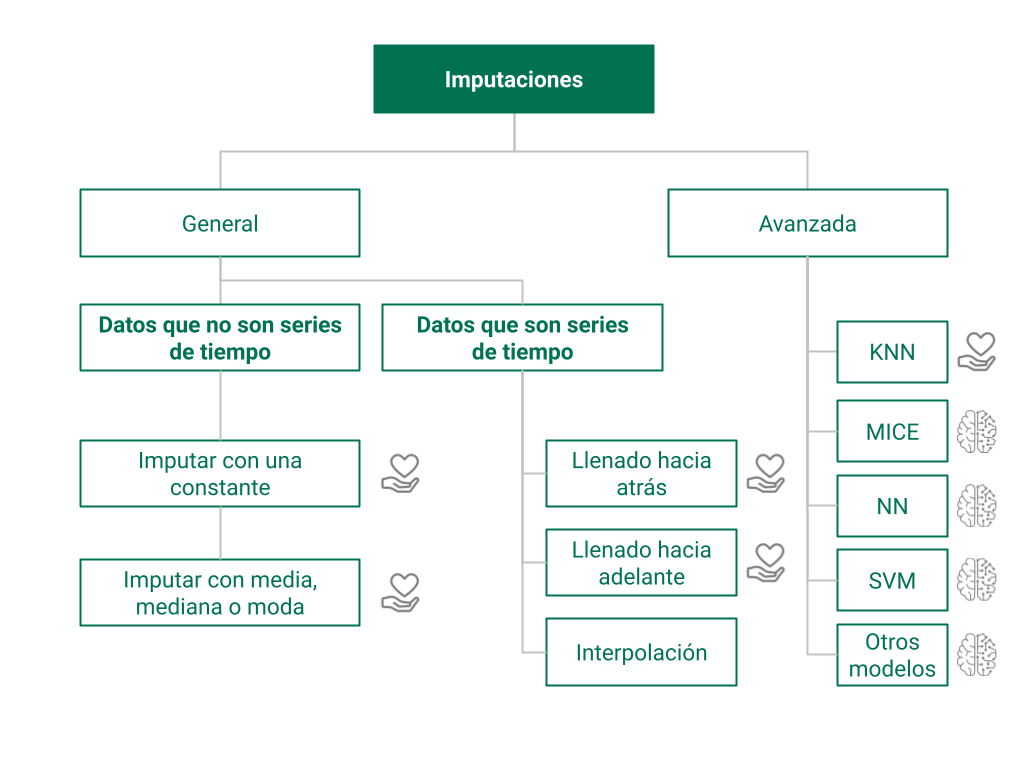

In [27]:
Image("/root/Platzi/CurDatosFalt_2/Images/imputation_methods.png")

## Imputaciones basadas en el donante: (manita con corazoncito)

completa los valores que faltan copiando valores observados en el donante

## Unputaciones basadas en modelos: (cerebro)

encuentra un modelo predictivo y llena los valores faltantes bajo la formula que suelta el modelo

La interpolación es mixta

# Imputación de media, mediana y moda

## Pros:

Facil y rapido de implementar, La media es util en presencia de outliners, no afecta el estadistico en cuestion (media, moda, mediana) y no cambia el tamaño de la muestra

## Contras:

Puede sesgar los resultados por debajo (curtosis), se pierde correlacion entre variables, No se pueden usar variables categoricas salvo por la moda.

In [28]:
(
    nhanes_df
    .transform_column(
        "height",
        lambda x: x.fillna(x.mean()),
        elementwise=False
    )
)

,height,weight,general_health_condition,total_cholesterol,pulse,diabetes,gender,age
SEQN,,,,,,,,
93703.0,66.25656,NaN,NaN,NaN,NaN,0,Female,2.0
93704.0,66.25656,NaN,NaN,NaN,NaN,0,Male,2.0
93705.0,63.00000,165.0,Good,157.0,52.0,0,Female,66.0
93706.0,68.00000,145.0,Very good,148.0,82.0,0,Male,18.0
93707.0,66.25656,NaN,Good,189.0,100.0,0,Male,13.0
...,...,...,...,...,...,...,...,...
102951.0,66.25656,NaN,NaN,NaN,NaN,0,Male,4.0
102953.0,65.00000,218.0,Fair or,182.0,78.0,0,Male,42.0
102954.0,66.00000,150.0,Good,172.0,78.0,0,Female,41.0


<Axes: xlabel='height', ylabel='weight'>

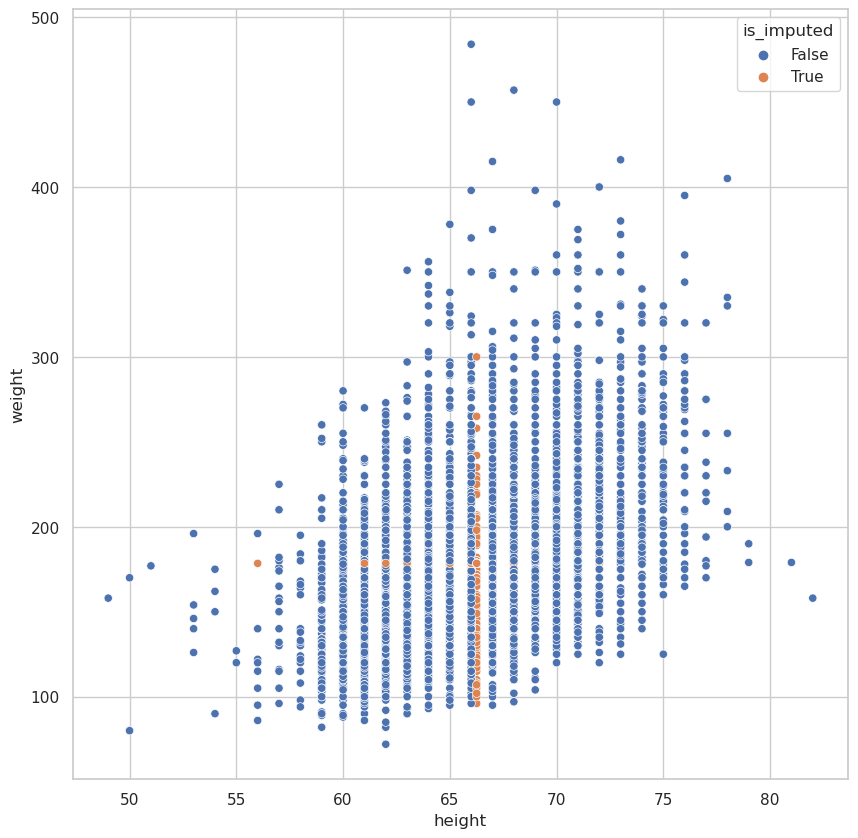

In [29]:
plt.figure(figsize=(10, 10))

(
    nhanes_df
    .select_columns("height", "weight")
    .missing.bind_shadow_matrix(True, False, suffix = "_imp")
    .assign(
        height = lambda df: df.height.fillna(value = df.height.mean()),
        weight = lambda df: df.weight.fillna(value = df.weight.mean())
    )
    .missing.scatter_imputation_plot(x="height", y="weight")
)

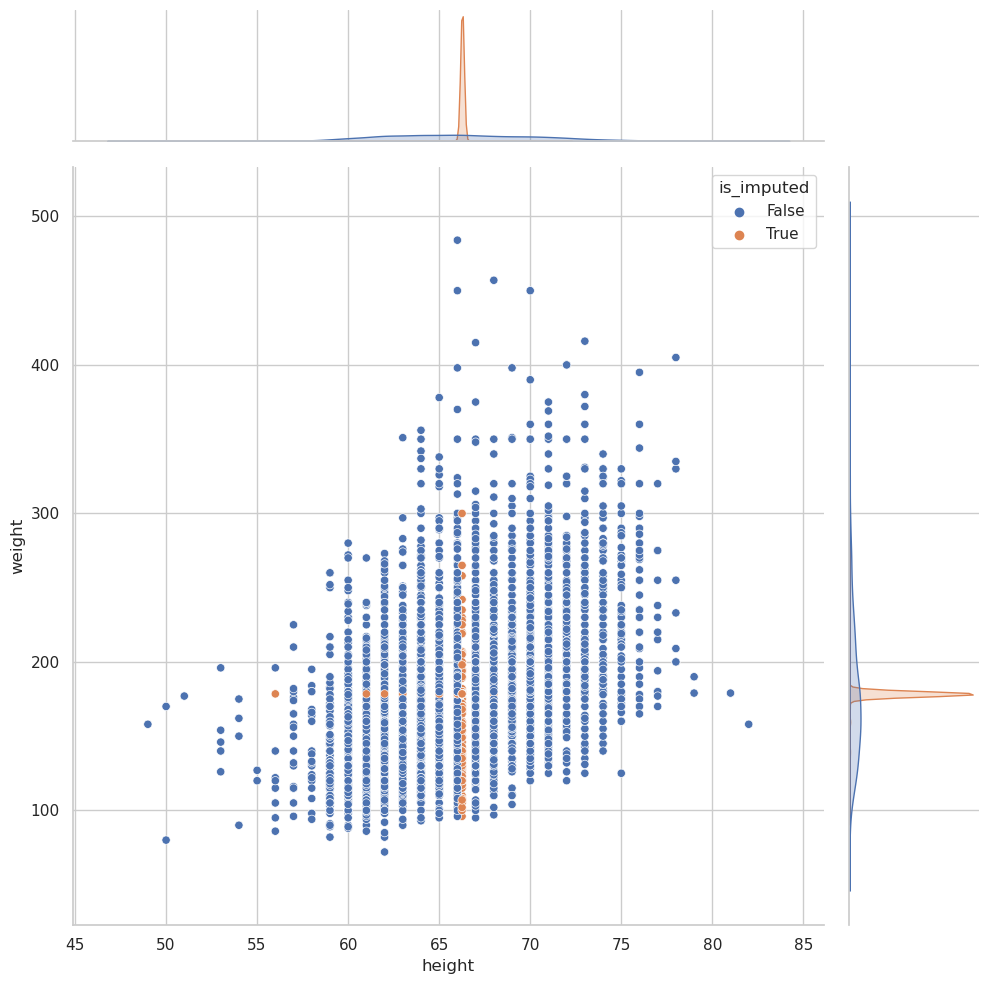

In [30]:
(
    nhanes_df.select_columns("height", "weight")
    .missing.bind_shadow_matrix(True, False, suffix="_imp")
    .assign(
        height=lambda df: df.height.fillna(value=df.height.mean()),
        weight=lambda df: df.weight.fillna(value=df.weight.mean()),
    )
    .missing.scatter_imputation_plot(
        x="height",
        y="weight",
        show_marginal=True,
        height=10
    )
)

# Llenado hacia atras o adelante

Se trata de llenar los valores faltantes con el mas cercano hacia arriba o hacia abajo que no es faltante

## Pros:

Es rapido y facil, los datos imputados no son constantes como en el metodo anterior, existen trucos para evitar romper relaciones entre variables

## Contras:

La relaciones entre variabes pueden ser distorcionadas

## fillna() vs ffill() o bfill()

In [31]:
nhanes_df.fillna(method="bfill").bfill()

,height,weight,general_health_condition,total_cholesterol,pulse,diabetes,gender,age
SEQN,,,,,,,,
93703.0,63.0,165.0,Good,157.0,52.0,0,Female,2.0
93704.0,63.0,165.0,Good,157.0,52.0,0,Male,2.0
93705.0,63.0,165.0,Good,157.0,52.0,0,Female,66.0
93706.0,68.0,145.0,Very good,148.0,82.0,0,Male,18.0
93707.0,62.0,200.0,Good,189.0,100.0,0,Male,13.0
...,...,...,...,...,...,...,...,...
102951.0,65.0,218.0,Fair or,182.0,78.0,0,Male,4.0
102953.0,65.0,218.0,Fair or,182.0,78.0,0,Male,42.0
102954.0,66.0,150.0,Good,172.0,78.0,0,Female,41.0


se pueden perder correlaciones lineales. Lo optimo seria organizar por tipos de datos similares, en este caso priemro genero para que los datos de mujeres se rellenen solo con datos de mujeres, luego por condicion general de salud y luego si rellenamos hacia adelante.

In [32]:
(
    nhanes_df
    .select_columns("height", "weight", "gender", "diabetes", "general_health_condition")
    .sort_values(
        by=['gender','diabetes','general_health_condition','weight'],
        ascending=True
    )
    .groupby(["gender", "general_health_condition"], dropna=False)
    .apply(lambda x: x.ffill())
)

height  weight  gender  diabetes  \
gender general_health_condition SEQN                                         
Female Excellent                94195.0     63.0    90.0  Female         0   
                                95793.0     61.0    96.0  Female         0   
                                101420.0    59.0    98.0  Female         0   
                                94148.0     65.0   100.0  Female         0   
                                102062.0    62.0   100.0  Female         0   
...                                          ...     ...     ...       ...   
Male   NaN                      96561.0     74.0   290.0    Male         1   
                                96869.0     72.0   298.0    Male         1   
                                97267.0     72.0   298.0    Male         1   
                                97856.0     72.0   298.0    Male         1   
                                98317.0     72.0   298.0    Male         1   

                                         general_health_condition  
gender general_health_condition SEQN                               
Female Excellent                94195.0                 Excellent  
                                95793.0                 Excellent  
                                101420.0                Excellent  
                                94148.0                 Excellent  
                                102062.0                Excellent  
...                                                           ...  
Male   NaN                      96561.0                       NaN  
                                96869.0                       NaN  
                                97267.0                       NaN  
                                97856.0                       NaN  
                                98317.0                       NaN  

[8187 rows x 5 columns]

# Imputación por interpolación

Ejemplo llenado hacia adelante 

<Axes: xlabel='date'>

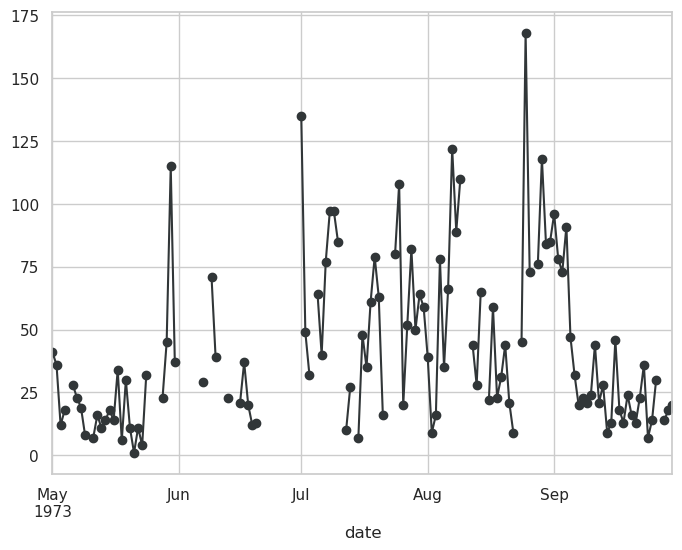

In [33]:
(
    airquality_df
    .select_columns("ozone")
    .pipe(
        lambda df: (
            df.ozone.plot(color = "#313638", marker = "o")
        )
    )
)

(<Axes: xlabel='date'>, <Axes: xlabel='date'>)

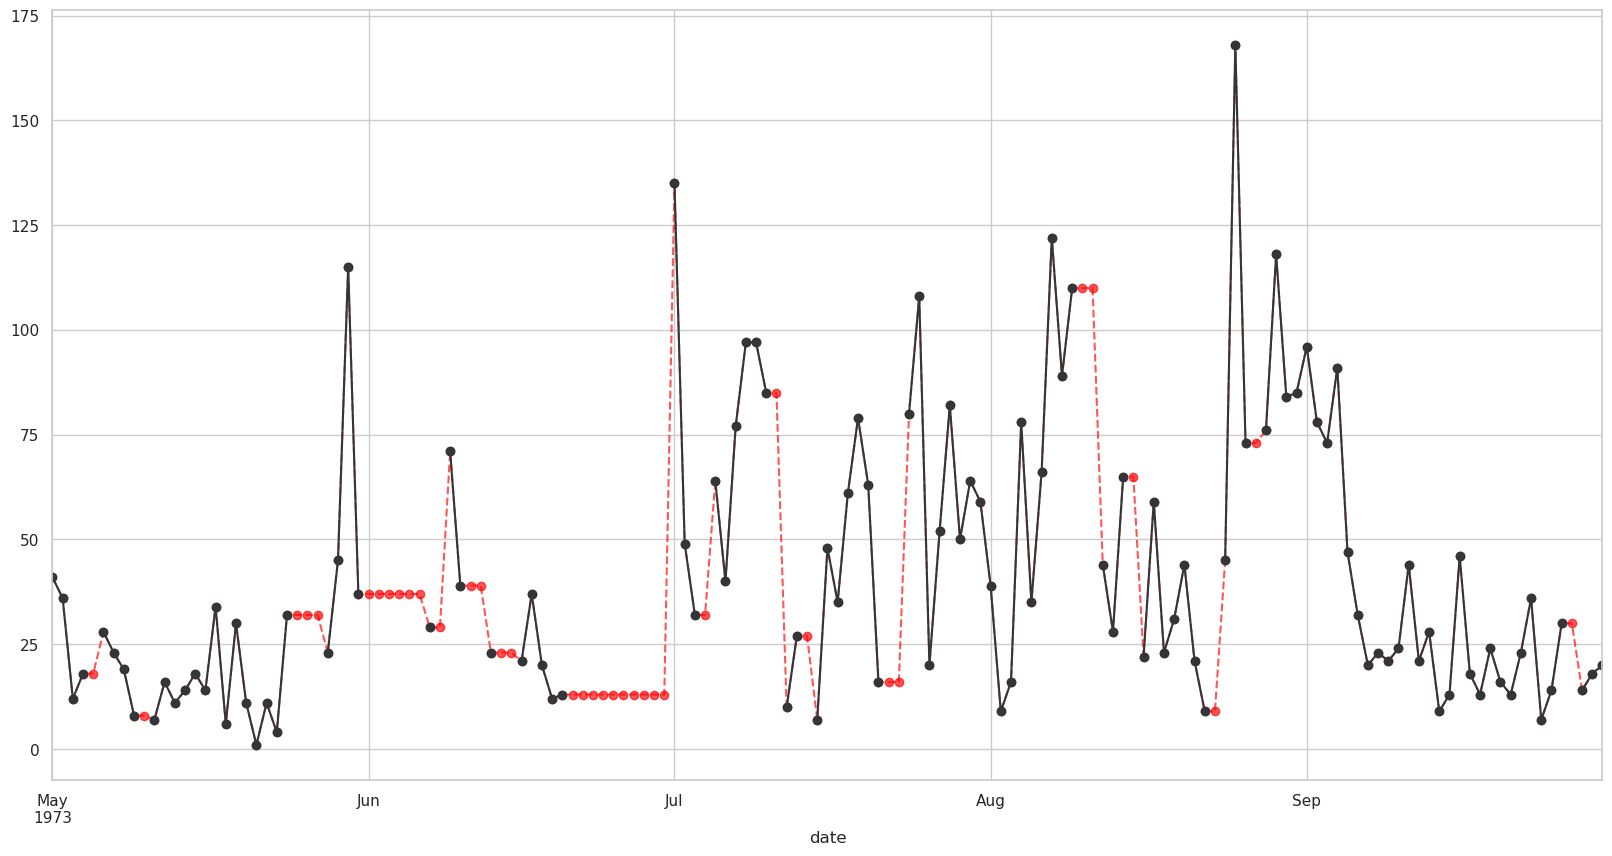

In [34]:
plt.figure(figsize=(20,10))

(
    airquality_df
    .select_columns("ozone")
    .pipe(
        lambda df: (
            df.ozone.ffill().plot(color = "red", marker = "o", alpha=6/9, linestyle = "dashed"),
            df.ozone.plot(color = "#313638", marker = "o")
        )
    )
)

De forma lineal: (hay mas, quadratic, pchip, nearest, akima)

(<Axes: xlabel='date'>, <Axes: xlabel='date'>)

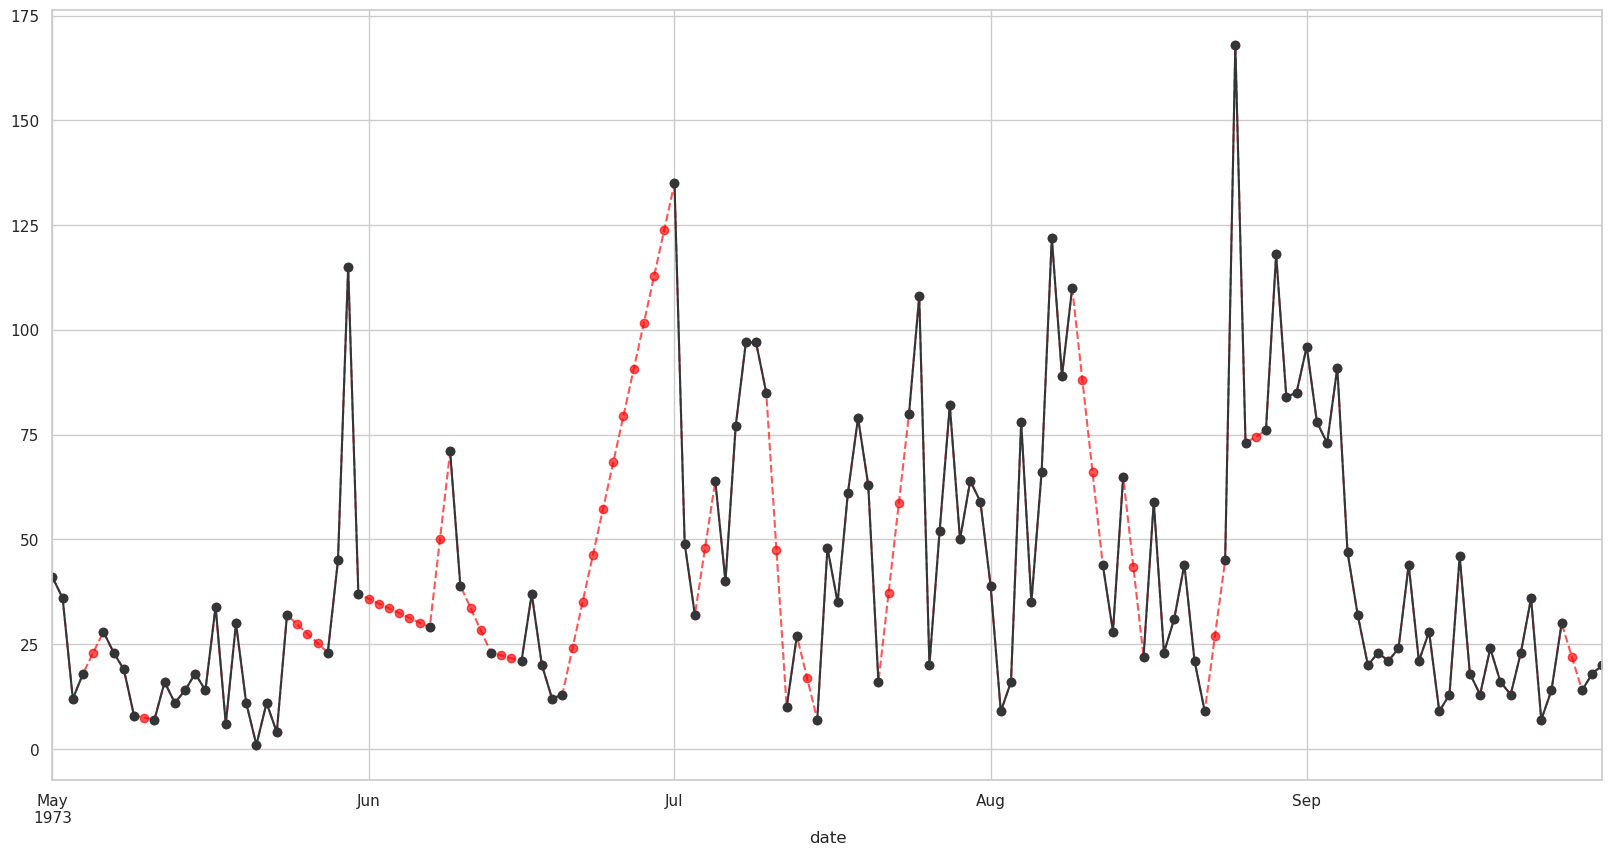

In [35]:
plt.figure(figsize=(20,10))

(
    airquality_df
    .select_columns("ozone")
    .pipe(
        lambda df: (
            df.ozone.interpolate(method = "linear").plot(color = "red", marker = "o", alpha=6/9, linestyle = "dashed"),
            df.ozone.plot(color = "#313638", marker = "o")
        )
    )
)

# Imputación de los k-vecinos mas cercanos (KNN)

Lo que hacemos es asignar los datos mas "cercanos" a los valores faltantes usando alguna métrica especifica. Para variables numericas se utiliza la distancia euclidiana, para variables tipo factor (como los dias de la semana o el genero y vueltas asi como discretas pero no numericas) la metrica del taxista y para variables categoricas se utiliza la distancia de Hamming (Una palabra dista de otra en base a la cantidad de letras por las que difieren). En base a todas esas distancias se define la $\textbf{"Métrica de Gower"}$ para variables sea cual sea su tipo.  
  
Pros:  
-Fácil de implemetar  
-Buen rendimiento  
-Excelente para datos mixtos  
  
Contras:  
-Difícil de escalar  
-Las variables categoricas requieren transformaciones  
-Demasiada sensibilidad a los outliners  
  
Es bueno escalar los datos antes de aplicar el algoritmo

In [36]:
nhanes_transformed_df

,general_health_condition,gender,height,weight,total_cholesterol,pulse,diabetes,age
SEQN,,,,,,,,
93703.0,NaN,0.0,NaN,NaN,NaN,NaN,0.0,2.0
93704.0,NaN,1.0,NaN,NaN,NaN,NaN,0.0,2.0
93705.0,2.0,0.0,63.0,165.0,157.0,52.0,0.0,66.0
93706.0,4.0,1.0,68.0,145.0,148.0,82.0,0.0,18.0
93707.0,2.0,1.0,NaN,NaN,189.0,100.0,0.0,13.0
...,...,...,...,...,...,...,...,...
102951.0,NaN,1.0,NaN,NaN,NaN,NaN,0.0,4.0
102953.0,1.0,1.0,65.0,218.0,182.0,78.0,0.0,42.0
102954.0,2.0,0.0,66.0,150.0,172.0,78.0,0.0,41.0


In [37]:
knn_imputer = sklearn.impute.KNNImputer()

nhanes_df_knn = nhanes_transformed_df.copy(deep=True)

nhanes_df_knn.iloc[:, :] = knn_imputer.fit_transform(nhanes_df_knn).round() #.round() para redondear
nhanes_df_knn

,general_health_condition,gender,height,weight,total_cholesterol,pulse,diabetes,age
SEQN,,,,,,,,
93703.0,2.0,0.0,63.0,137.0,151.0,91.0,0.0,2.0
93704.0,2.0,1.0,71.0,152.0,164.0,86.0,0.0,2.0
93705.0,2.0,0.0,63.0,165.0,157.0,52.0,0.0,66.0
93706.0,4.0,1.0,68.0,145.0,148.0,82.0,0.0,18.0
93707.0,2.0,1.0,69.0,130.0,189.0,100.0,0.0,13.0
...,...,...,...,...,...,...,...,...
102951.0,2.0,1.0,71.0,152.0,164.0,86.0,0.0,4.0
102953.0,1.0,1.0,65.0,218.0,182.0,78.0,0.0,42.0
102954.0,2.0,0.0,66.0,150.0,172.0,78.0,0.0,41.0


<Axes: xlabel='height', ylabel='weight'>

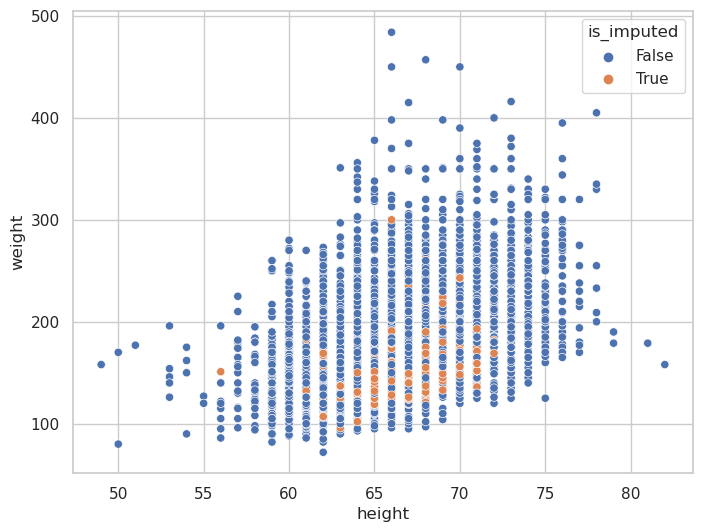

In [38]:
(
    pd.concat(
        [
            nhanes_df_knn,
            nhanes_df.missing.create_shadow_matrix(True, False, suffix="_imp", only_missing=True)
        ],
        axis=1
    )
    .missing.scatter_imputation_plot(x="height", y="weight")
)

Como se vio antes, es mejor imputar datos cuando estan organizados en base a dominios (genero y cosas asi discretas y generales) porque los valores se llenan en base a otros datos mas relacionados. 

<Axes: xlabel='height', ylabel='weight'>

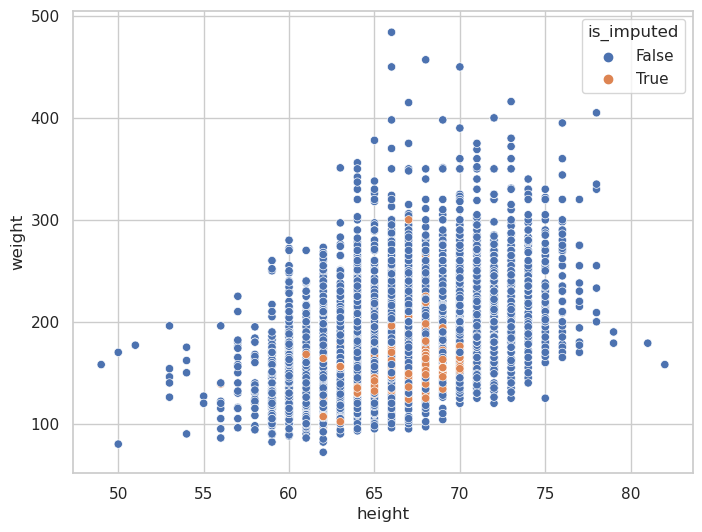

In [39]:
knn_imputer = sklearn.impute.KNNImputer(n_neighbors = 10)

nhanes_df_knn = nhanes_transformed_df.missing.sort_variables_by_missingness(ascending=True).copy(deep=True)

nhanes_df_knn.iloc[:, :] = knn_imputer.fit_transform(nhanes_df_knn).round()

(
    pd.concat(
        [
            nhanes_df_knn,
            nhanes_df.missing.create_shadow_matrix(True, False, suffix="_imp", only_missing=True)
        ],
        axis=1
    )
    .missing.scatter_imputation_plot(x="height", y="weight")
)

# Imputación en base a modelos  
  
Pros:  
-Mejor que la imputación por donantes  
-Gran variedad de formas para imputar los datos  
-Preserva la relación entre las variables  
  
Contras:  
-Aveces se subestima la varianza  
-Si los valores observados y los faltantes son independientes los modelos funcionan mal  
-Mas complicado que la imputación por donantes

# Regresión lineal

In [48]:
nhanes_model_df = (
    nhanes_df
    .select_columns("height", "weight", "gender", "age")
    .sort_values(by = "height")
    .transform_column(
        "weight",
        lambda x: x.ffill(),
        elementwise = False
    )
    .missing.bind_shadow_matrix(
        True,
        False,
        suffix = "_imp"
    )
)

nhanes_model_df

,height,weight,gender,age,height_imp,weight_imp,gender_imp,age_imp
SEQN,,,,,,,,
94940.0,49.0,158.0,Female,80.0,False,False,False,False
96508.0,50.0,170.0,Female,46.0,False,False,False,False
97877.0,50.0,80.0,Female,29.0,False,False,False,False
102379.0,51.0,177.0,Female,71.0,False,False,False,False
99705.0,53.0,196.0,Female,40.0,False,False,False,False
...,...,...,...,...,...,...,...,...
102939.0,NaN,107.0,Female,2.0,True,False,False,False
102941.0,NaN,107.0,Female,14.0,True,False,False,False
102945.0,NaN,107.0,Male,15.0,True,False,False,False


In [47]:
height_ols = (
    nhanes_model_df
    .pipe(
        lambda df: smf.ols("height ~ weight + gender + age",  data=df)
    )
    .fit()
)

In [49]:
ols_imputed_values = (
    nhanes_model_df
    .pipe(
        lambda df: df[df.height.isna()]
    )
    .pipe(
        lambda df: height_ols.predict(df).round()
    )
)

ols_imputed_values

SEQN
93703.0     64.0
93704.0     69.0
93707.0     69.0
93719.0     64.0
93720.0     64.0
            ... 
102939.0    63.0
102941.0    63.0
102945.0    68.0
102951.0    68.0
102955.0    63.0
Length: 2699, dtype: float64

In [51]:
nhanes_model_df.loc[nhanes_model_df.height.isna(), ["height"]] = ols_imputed_values

nhanes_model_df

,height,weight,gender,age,height_imp,weight_imp,gender_imp,age_imp
SEQN,,,,,,,,
94940.0,49.0,158.0,Female,80.0,False,False,False,False
96508.0,50.0,170.0,Female,46.0,False,False,False,False
97877.0,50.0,80.0,Female,29.0,False,False,False,False
102379.0,51.0,177.0,Female,71.0,False,False,False,False
99705.0,53.0,196.0,Female,40.0,False,False,False,False
...,...,...,...,...,...,...,...,...
102939.0,63.0,107.0,Female,2.0,True,False,False,False
102941.0,63.0,107.0,Female,14.0,True,False,False,False
102945.0,68.0,107.0,Male,15.0,True,False,False,False


<Axes: xlabel='height', ylabel='weight'>

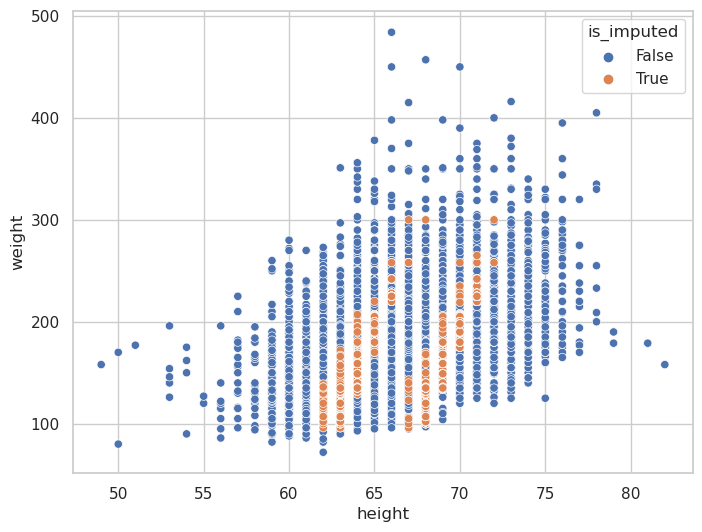

In [52]:
(
    nhanes_model_df
    .missing
    .scatter_imputation_plot(
        x = "height",
        y = "weight"
    )
)

# Imputación múltiples por ecuaciones encadenadas

Mucho texto. Hay que estudiarlo bién en la Universidad

Pros:  
-Mantiene la distribución de los datos  
-Optima para MNAR y MAR  

Contras:  
-Mucho texto

<Axes: xlabel='height', ylabel='weight'>

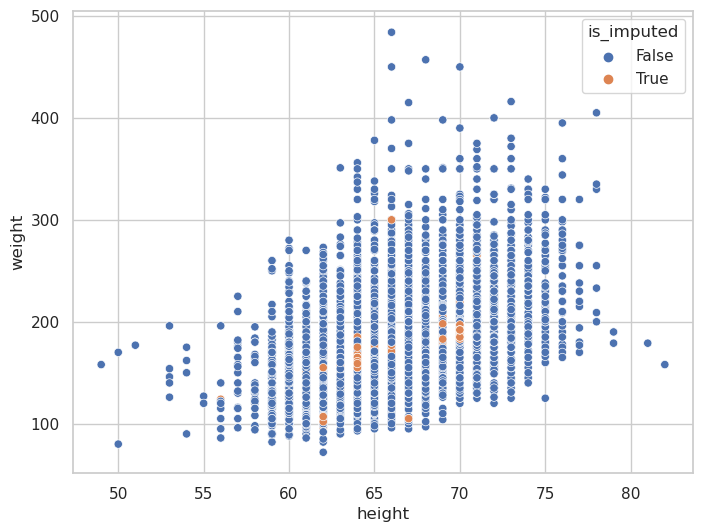

In [54]:
mice_imputer = sklearn.impute.IterativeImputer(estimator=BayesianRidge())

nhanes_mice_df = nhanes_transformed_df.copy(deep = True)

nhanes_mice_df.iloc[:, :] = mice_imputer.fit_transform(nhanes_mice_df).round()

nhanes_mice_df = pd.concat(
    [
        nhanes_mice_df,
        nhanes_df.missing.create_shadow_matrix(True, False, suffix="_imp", only_missing=True)
    ],
    axis = 1
)

nhanes_mice_df.missing.scatter_imputation_plot(
    x = "height",
    y = "weight"
)

# Transformación inversa de datos

In [55]:
nhanes_imputated_df = nhanes_mice_df.copy(deep=True)

nhanes_imputated_df[categorical_columns] = (
    categorical_transformer
    .named_transformers_
    .ordinalencoder
    .inverse_transform(
        X = nhanes_mice_df[categorical_columns]
    )
)

nhanes_imputated_df

,general_health_condition,gender,height,weight,total_cholesterol,pulse,diabetes,age,height_imp,weight_imp,general_health_condition_imp,total_cholesterol_imp,pulse_imp
SEQN,,,,,,,,,,,,,
93703.0,Good,Female,64.0,165.0,162.0,82.0,0.0,2.0,True,True,True,True,True
93704.0,Good,Male,70.0,192.0,156.0,80.0,0.0,2.0,True,True,True,True,True
93705.0,Good,Female,63.0,165.0,157.0,52.0,0.0,66.0,False,False,False,False,False
93706.0,Very good,Male,68.0,145.0,148.0,82.0,0.0,18.0,False,False,False,False,False
93707.0,Good,Male,70.0,200.0,189.0,100.0,0.0,13.0,True,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
102951.0,Good,Male,70.0,192.0,157.0,79.0,0.0,4.0,True,True,True,True,True
102953.0,Fair or,Male,65.0,218.0,182.0,78.0,0.0,42.0,False,False,False,False,False
102954.0,Good,Female,66.0,150.0,172.0,78.0,0.0,41.0,False,False,False,False,False
